<a href="https://colab.research.google.com/github/nick01as/AI-ML-starter-kit/blob/nick01as-patch-1/ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TritonHacks 2025: Introduction to AI/ML Starter Kit Part II: Machine Learning (ML)

Welcome to the Intro to AI/ML Starter Kit for TritonHacks 2025! This is the second of two notebooks in this repo, and it focuses on creating ML models.

## Importing Libraries
Like always, we will begin by importing libraries. In this notebook, we'll use SciKit-Learn to help us train our models. The library offers a wide variety of tools that will make the training process much easier. Feel free to check out the official documentation on [SciKit-Learn's Website](https://scikit-learn.org/stable/) to see how these functions work under the hood.

In [1]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd

## Importing Data
We'll also need to import our data. Check out `Importing Data` in the EDA file for more detailed instructions on this step.

In [2]:
from google.colab import files
uploaded = files.upload()
path_to_file = 'healthcare-dataset-stroke-data.csv'

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv


In [168]:
path_to_file = 'healthcare-dataset-stroke-data.csv' # REPLACE WITH PATH TO YOUR FILE

# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')
path_to_file = '/content/drive/MyDrive/' + path_to_file

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df = pd.read_csv(path_to_file)

## Preprocessing
Now, we need to get our data ready for training. In the EDA file, we identified explanatory variables and analyzed a few graphs showing the relationship between them. In this notebook, we will train our model on the following variables: gender, age, hypertension, heart disease, avg. glucose level, BMI, and smoking status. Feel free to play around with the selection to see which combination yield a better model.

Let's first remove the variables we don't need and look at the new dataframe:

In [5]:
df = df.drop(['ever_married', 'work_type', 'Residence_type'], axis = 1)
df.head()

,id,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,174.12,24.0,never smoked,1


### One Hot Encoding
Notice how entries in `gender` and `smoking_status` are formatted as *strings*. But wait, our ML model can't take strings as inputs! We need to perform **one-hot-encoding** (OHE) on the data to make sure all entries are expressed numerically. What this means is that each state a variable can take will be expressed as True/False or a set of 1s and 0s. Take `smoking_status` for instance–the variable can take on the values: formerly smoked, never smoked, smokes, or unknown. Once we OHE, we get the following values:

<center>

| | Formerly Smoked | Never Smoked | Smokes | Unknown | Status |
|:-| :-: | :-: | :-: | :-: | :-:|
|Person 1 | 1 | 0 | 0 | 0 | Formerly Smoked |
|Person 2 | 0 | 1 | 0 | 0 | Never Smoked |
|Person 3 | 0 | 0 | 1 | 0 | Smokes |
|Person 4 | 0 | 0 | 0 | 1 | Unknown |

</center>

Let's edit the dataframe to OHE both `gender` and `smoking_status`

In [6]:
# One-hot encoding

one_hot = pd.get_dummies(
    df,
    columns=['gender', 'smoking_status'],
    prefix=['gender', 'smoking']
)
df = one_hot
df = df.fillna(df.median(numeric_only=True))
df.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,smoking_Unknown,smoking_formerly smoked,smoking_never smoked,smoking_smokes
0,9046,67.0,0,1,228.69,36.6,1,False,True,False,False,True,False,False
1,51676,61.0,0,0,202.21,28.1,1,True,False,False,False,False,True,False
2,31112,80.0,0,1,105.92,32.5,1,False,True,False,False,False,True,False
3,60182,49.0,0,0,171.23,34.4,1,True,False,False,False,False,False,True
4,1665,79.0,1,0,174.12,24.0,1,True,False,False,False,False,True,False


Now, we need to separate our explanatory and response variables. The explanatory variables (commonly denoted `X`) are used as inputs to train the model while the response variables (commonly denoted `y`) give us the actual values to tell us how good our model is.

In [7]:
# Define X and y

X = df.drop(["stroke", "id"], axis = 1)
y = df["stroke"]

Recall that in the EDA notebook, we discussed a few data normalization processes. We'll use SciKit-Learn's **Z-score normalization** to rescale `age`, `avg_glucose_level`, and `bmi` so that their values don't dominate the training process. (The variance in the values are larger so the ML model is more prone to fit along these variables and overlook others).

In [8]:
# Scaling dominant numeric features

to_scale = ['age', 'avg_glucose_level', 'bmi']
not_scaled = [col for col in X.columns if col not in to_scale]

scaler = StandardScaler() # Z-score normalization
scaled_part = scaler.fit_transform(X[to_scale])
scaled_df = pd.DataFrame(scaled_part, columns=to_scale)

X = pd.concat([scaled_df, X[not_scaled].reset_index(drop=True)], axis=1)

### Train Test Split
But wait, if we train our model on 100% of the data, how do we evaluate the quality of our model? We need the `train_test_split` function to divide the data into two batches. One batch is used to *train* the model and the other to *test* the model. Typically, the 70-80% of the data is allocated for training and the remaining 20-30% for testing.

However, there's still a small issue...in the EDA notebook, we saw that the number of datapoints for non-stroke cases is significantly larger than the number of datapoints for stroke cases. On any given train-test split, there's a good chance that the majority of the data is just non-stroke cases. That's not very useful for our model because it doesn't learn to differentiate between stroke and non-stroke. To solve this imbalance in data, we will *undersample* the non-stroke class until we get roughly similar proportions between stroke/non-stroke cases.

In [9]:
# Train-Test Spliting
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 0)

## Training a Model
### Add linear classifier here

### Precision-Recall Curves (PR Curve)
In the linear classifier, we quantified the performance of our model by looking at the proportion of predictions that were correct. Another way to analyze the quality of our model is using a precision-recall curve (PR curve). The graph plots the precision v. recall values for a given model at each decision threshold level.

**Precision:**
The precision measures the proportion of True Positives predicted by the model out of all positive predictions (True Positive + False Positive). It is calculated as:
$$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

**Recall:**
The recall measures the proportion of True Positives predicted by the model out of all *actual* positive values (True Positive + False Negative). It is given by:
$$\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

When we train a model, the model actually outputs its predication as a probability. If the value is larger than the decision threshold of 0.5, the model outputs "stroke" and then vise versa otherwise. In a precision-recall curve, we vary this threshold value and observe how the precision and recall of the model respond. The area under the curve (AUC) represents how well the model performes.

In [11]:
from sklearn.metrics import precision_recall_curve, auc
from matplotlib import pyplot as plt

def precision_recall_score(X_data, y_data, model):
  y_scores = model.predict_proba(X_test)[:, 1]
  precision, recall, thresholds = precision_recall_curve(y_data, y_scores)
  auc_score = auc(recall, precision)

  # Plot precision-recall curve
  plt.figure(figsize=(8, 6))
  plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend()
  plt.show()

  return precision, recall, auc_score

In [ ]:
# from sklearn.model_selection import KFold, cross_val_score

# mlp = MLPClassifier(hidden_layer_sizes = (64, 32), max_iter = 1000, random_state = 0)
# k_folds = KFold(n_splits = 5, shuffle = True, random_state = 0)
# scores = cross_val_score(mlp, X, y, cv = k_folds)
# print(scores, scores.mean())

### KNN Classifier

Accuracy: 0.78


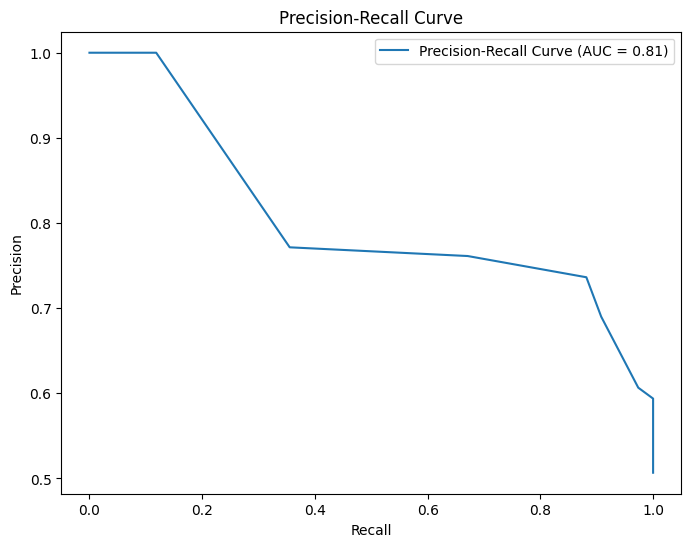

AUC Score: 0.8050257242507985


In [13]:
# KNN Classification
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors = 9)
KNN.fit(X_train, y_train)
y_predicted = KNN.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
print(f'Accuracy: {acc}')

precision, recall, auc_score = precision_recall_score(X_test, y_test, KNN)
print(f'AUC Score: {auc_score}')

### Decision Tree Classifier

Accuracy: 0.74


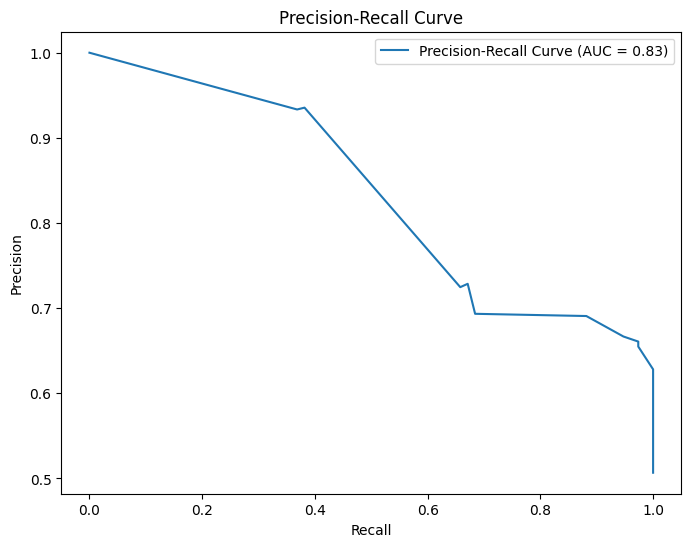

AUC Score: 0.8322913032375536


In [14]:
from sklearn.tree import DecisionTreeClassifier as DT

dt = DT(max_depth = 4, random_state = 42)
dt.fit(X_train, y_train)
accuracy = dt.score(X_test, y_test)
print(f"Accuracy: {accuracy}")
precision, recall, auc_score = precision_recall_score(X_test, y_test, dt)
print(f'AUC Score: {auc_score}')

#### Visualization

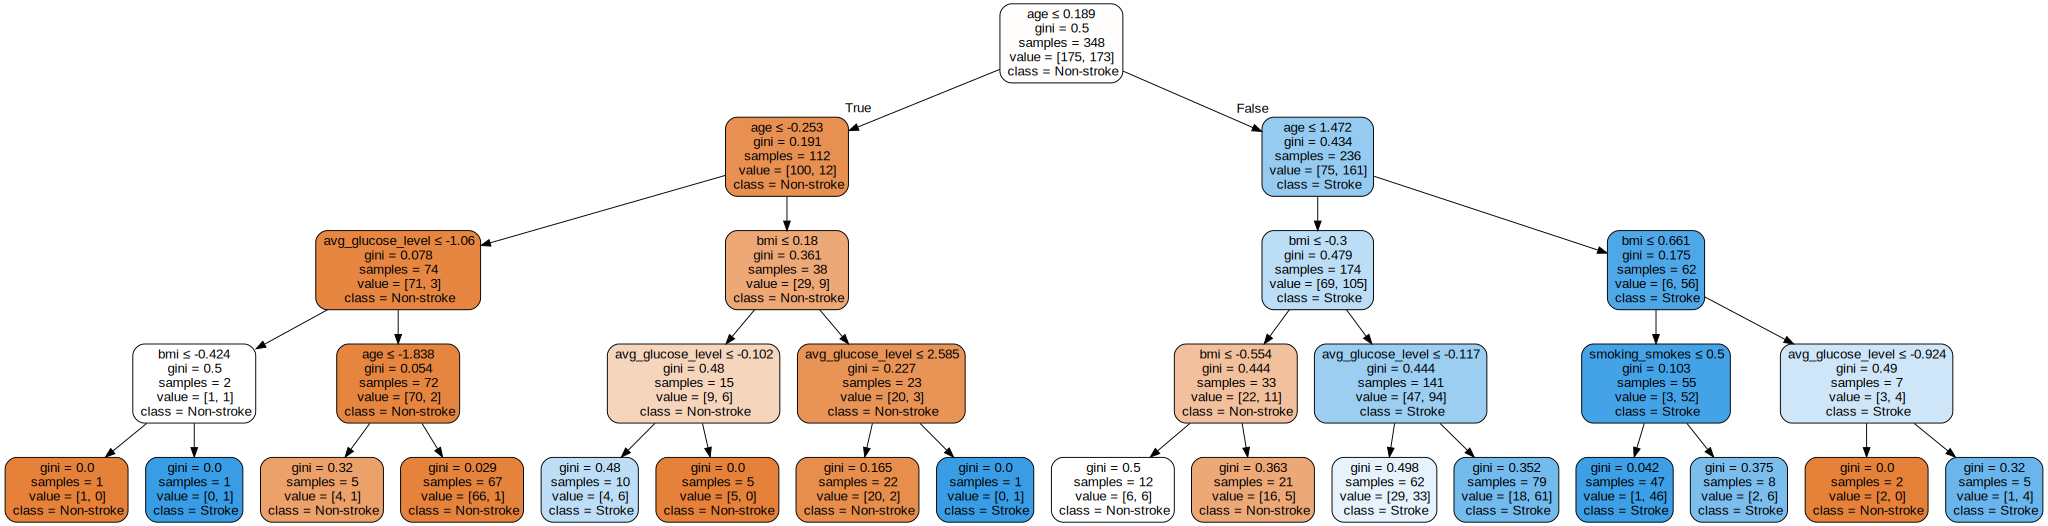

In [15]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(dt, out_file=None, feature_names=X.columns, class_names=['Non-stroke', 'Stroke'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Random Forest

Accuracy: 0.7933333333333333


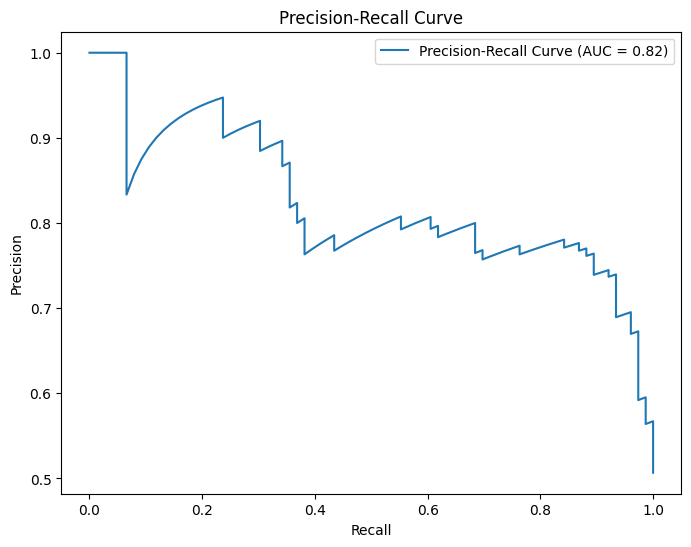

AUC Score: 0.8218135064360533


In [16]:
from sklearn.ensemble import RandomForestClassifier as RF

rf = RF(n_estimators = 100, max_depth = 4, random_state = 0)
rf.fit(X_train, y_train)
accuracy = rf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

precision, recall, auc_score = precision_recall_score(X_test, y_test, rf)
print(f'AUC Score: {auc_score}')

### Multi-layer Perceptron (MLP)

0.7066666666666667


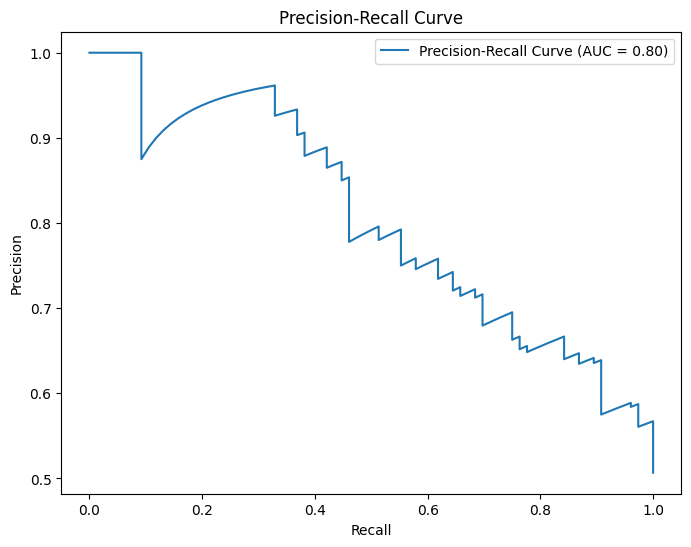

AUC Score: 0.8023024952589001


In [182]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes = (256, 128), max_iter = 1000, random_state = 0)
mlp.fit(X_train, y_train)
y_predicted = mlp.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
print(acc)

precision, recall, auc_score = precision_recall_score(X_test, y_test, mlp)
print(f'AUC Score: {auc_score}')